<a href="https://colab.research.google.com/github/ali-workshop/LLM-notebook-sentiment-analysis/blob/main/LLM_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets --quiet
!pip install nlpaug --quiet
!pip install sacremoses --quiet
!pip install --upgrade gensim --quiet
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import libraries
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import torch
import re
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, auc


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [ ]:
# Function to clean text data
def preprocessor(sample):
  text = sample["text"]

  stop_words = set(stopwords.words('english'))

  # Remove all html markup from a tweet
  text = re.sub('<[^>]*>', '', text)

  # Remove http links from a tweet
  text = re.sub('http[^\s]+', '', text)

  tokenizer_text = nltk.tokenize.TreebankWordTokenizer()

  tokens = tokenizer_text.tokenize(text)

  tokens = [tok for tok in tokens if tok not in stop_words]

  text = ' '.join([tok for tok in tokens])

  sample["text"] = text

  return sample

In [ ]:
ds = ds.map(preprocessor, batched = False)

Parameter 'function'=<function preprocessor at 0x7ff378a7b760> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

# DistilBERT Model

In [ ]:
model_distilbert_name = "distilbert-base-uncased"
tokenizer_distilbert = AutoTokenizer.from_pretrained(model_distilbert_name)

In [ ]:
# Function to tokenize a batch of examples
def tokenizing(sample):
  return tokenizer_distilbert(
    sample["text"],
    # Padding with zero to have the same length
    padding = True,
    # Truncate the examples to the model’s maximum context size (which is 512 for this model)
    truncation = True)

In [ ]:
ds_encoded = ds.map(tokenizing, batched = True, batch_size = None)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
# text is the tweets text
# label is the sentiment label
# input_ids is a numerical representations of the text data which created by tokenizing the raw text where each token in the text is mapped to a unique integer ID according to a predefined vocabulary.
# attention_mask is a binary mask that indicates which tokens should be attended to by the model and which should be ignored.
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2388
    })
})

In [ ]:
# Remove the text column from the ds_encoded because the model does not use it.
ds_encoded = ds_encoded.remove_columns(['text'])

# converting the label, input_ids, and attention_mask columns to the "torch" format.
ds_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [ ]:
# Use GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
label2id = {}
id2label = {}
labels = ['Bearish', 'Bullish', 'Neutral']
for i, label_name in enumerate(labels):
  label2id[label_name] = str(i)
  id2label[str(i)] = label_name

label2id, id2label, len(label2id)

({'Bearish': '0', 'Bullish': '1', 'Neutral': '2'},
 {'0': 'Bearish', '1': 'Bullish', '2': 'Neutral'},
 3)

In [ ]:
# Pre-trained model with a classification head
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_distilbert_name,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a function to compute two metrics--accuracy and f1 score
def compute_metrics(pred):
  # True labels
  labels = pred.label_ids
  # Predicted labels
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  precision = precision_score(labels, preds, average = "weighted")
  recall = recall_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Defining the training arguments
batch_size = 8
num_epochs = 5

# Name of the model
model_name = f"{model_distilbert_name}-finetuned-climate-change"

# Specify the path to store the fine-tuned model
path_model = '/content'

# Training argument
training_args = TrainingArguments(
  # Output directory
  output_dir = os.path.join(path_model, model_name),
  # Number of epochs
  num_train_epochs = num_epochs,
  # Learning rate
  learning_rate = 0.0001,
  # Batch size for training and validation
  per_device_train_batch_size = batch_size,
  # Weight decay for regularization
  weight_decay = 0.001,
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")

In [ ]:
# Define the trainer
trainer_distilbert = Trainer(
  # Model
  model = model_distilbert,
  # Training argument
  args = training_args,
  compute_metrics = compute_metrics,
  # Train and val Datasets
  train_dataset = ds_encoded["train"],
  # Tokenizer
  tokenizer = tokenizer_distilbert)

In [ ]:
# Start training
trainer_distilbert.train()

Step,Training Loss
500,0.703500
1000,0.550300
1500,0.452400
2000,0.370400
2500,0.331800
3000,0.244400
3500,0.224500
4000,0.140700
4500,0.129000
5000,0.118100


TrainOutput(global_step=5965, training_loss=0.2843878120109002, metrics={'train_runtime': 526.2021, 'train_samples_per_second': 90.678, 'train_steps_per_second': 11.336, 'total_flos': 962933559543540.0, 'train_loss': 0.2843878120109002, 'epoch': 5.0})

In [ ]:
# model_distilbert.save_pretrained(os.path.join(path_model, 'model_weights'))
# tokenizer_distilbert.save_pretrained(os.path.join(path_model, 'tokenizer_weights'))

('/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights/tokenizer_config.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights/special_tokens_map.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights/vocab.txt',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights/added_tokens.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights/tokenizer.json')

In [ ]:
model_distilbert_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/model_weights_distilbert"
tokenizer_distilbert_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_distilbert"

In [ ]:
model_load = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_distilbert_weights_path,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

In [ ]:
tokenizer_load = AutoTokenizer.from_pretrained(tokenizer_distilbert_weights_path)

In [ ]:
trainer2 = Trainer(
  model = model_load,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = ds_encoded["train"],
  tokenizer = tokenizer_load)

In [ ]:
preds_output = trainer2.predict(ds_encoded["validation"])
print(f"Accuracy: {round(preds_output.metrics['test_accuracy'] * 100, 4)} %")
print(f"Precision: {round(preds_output.metrics['test_precision'] * 100, 4)} %")
print(f"Recall: {round(preds_output.metrics['test_recall'] * 100, 4)} %")
print(f"F1 Score: {round(preds_output.metrics['test_f1'] * 100, 4)} %")

Accuracy: 86.139 %
Precision: 86.1204 %
Recall: 86.139 %
F1 Score: 86.1268 %


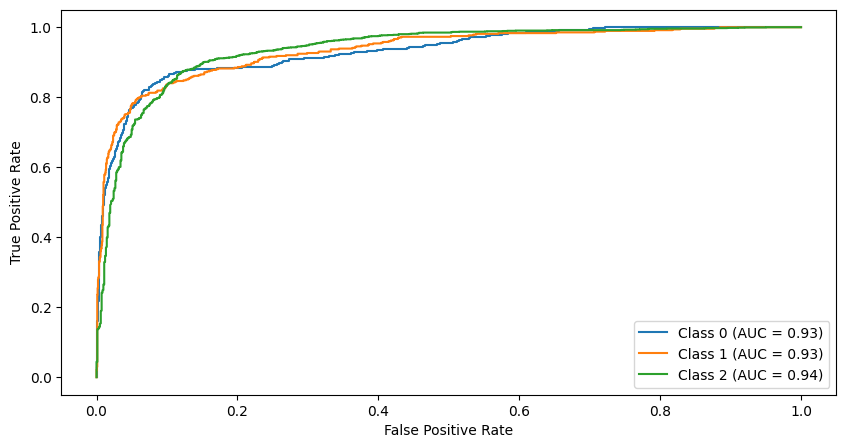

In [ ]:
y_pred_pro = np.exp(preds_output.predictions) / np.sum(np.exp(preds_output.predictions), axis=1, keepdims=True)
y_test = preds_output.label_ids
all_fpr = []
all_tpr = []
all_auc = []

for i in range(3):
    y_test_class = (y_test == i).astype(int)

    fpr, tpr, _ = roc_curve(y_test_class, y_pred_pro[:, i])

    roc_auc = auc(fpr, tpr)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)


plt.figure(figsize=(10, 5))

for i in range(3):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} (AUC = {all_auc[i]:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# RoBERTa Model

In [ ]:
model_RoBERTa_name = "cardiffnlp/twitter-roberta-base-sentiment"#"roberta-base"
tokenizer_RoBERTa = AutoTokenizer.from_pretrained(model_RoBERTa_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Function to tokenize a batch of examples
def tokenizing_RoBERTa(sample):
  return tokenizer_RoBERTa(
    sample["text"],
    # Padding with zero to have the same length
    padding = True,
    # Truncate the examples to the model’s maximum context size (which is 512 for this model)
    truncation = True)

In [ ]:
ds_encoded = ds.map(tokenizing_RoBERTa, batched = True, batch_size = None)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
# Remove the text column from the ds_encoded because the model does not use it.
ds_encoded = ds_encoded.remove_columns(['text'])

# converting the label, input_ids, and attention_mask columns to the "torch" format.
ds_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [ ]:
# Pre-trained model with a classification head
model_RoBERTa = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_RoBERTa_name,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Defining the training arguments
batch_size = 8
num_epochs = 5

# Name of the model
model_name = f"{model_RoBERTa_name}-finetuned-climate-change"

# Specify the path to store the fine-tuned model
path_model = '/content'

# Training argument
training_args = TrainingArguments(
  # Output directory
  output_dir = os.path.join(path_model, model_name),
  # Number of epochs
  num_train_epochs = num_epochs,
  # Learning rate
  learning_rate = 0.0001,
  # Batch size for training and validation
  per_device_train_batch_size = batch_size,
  # Weight decay for regularization
  weight_decay = 0.001,
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")

In [ ]:
# Define the trainer
trainer_RoBERTa = Trainer(
  # Model
  model = model_RoBERTa,
  # Training argument
  args = training_args,
  compute_metrics = compute_metrics,
  # Train and val Datasets
  train_dataset = ds_encoded["train"],
  # Tokenizer
  tokenizer = tokenizer_RoBERTa)

In [ ]:
# Start training
trainer_RoBERTa.train()

Step,Training Loss
500,0.837100
1000,0.797800
1500,0.811000
2000,0.815200
2500,0.771500
3000,0.766800
3500,0.827800
4000,0.731500
4500,0.668000
5000,0.677500


TrainOutput(global_step=5965, training_loss=0.7453954832551865, metrics={'train_runtime': 1153.7216, 'train_samples_per_second': 41.357, 'train_steps_per_second': 5.17, 'total_flos': 2501083176060420.0, 'train_loss': 0.7453954832551865, 'epoch': 5.0})

In [ ]:
# model_RoBERTa.save_pretrained(os.path.join("/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis", 'model_weights_RoBERTa'))
# tokenizer_RoBERTa.save_pretrained(os.path.join("/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis", 'tokenizer_weights_RoBERTa'))

('/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/tokenizer_config.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/special_tokens_map.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/vocab.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/merges.txt',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/added_tokens.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa/tokenizer.json')

In [ ]:
model_RoBERTa_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/model_weights_RoBERTa"
tokenizer_RoBERTa_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_RoBERTa"

In [ ]:
model_load = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_RoBERTa_weights_path,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

In [ ]:
tokenizer_load = AutoTokenizer.from_pretrained(tokenizer_RoBERTa_weights_path)

In [ ]:
trainer2 = Trainer(
  model = model_load,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = ds_encoded["train"],
  tokenizer = tokenizer_load)

In [ ]:
preds_output = trainer2.predict(ds_encoded["validation"])
print(f"Accuracy: {round(preds_output.metrics['test_accuracy'] * 100, 4)} %")
print(f"Precision: {round(preds_output.metrics['test_precision'] * 100, 4)} %")
print(f"Recall: {round(preds_output.metrics['test_recall'] * 100, 4)} %")
print(f"F1 Score: {round(preds_output.metrics['test_f1'] * 100, 4)} %")

Accuracy: 75.7119 %
Precision: 69.305 %
Recall: 75.7119 %
F1 Score: 70.6353 %


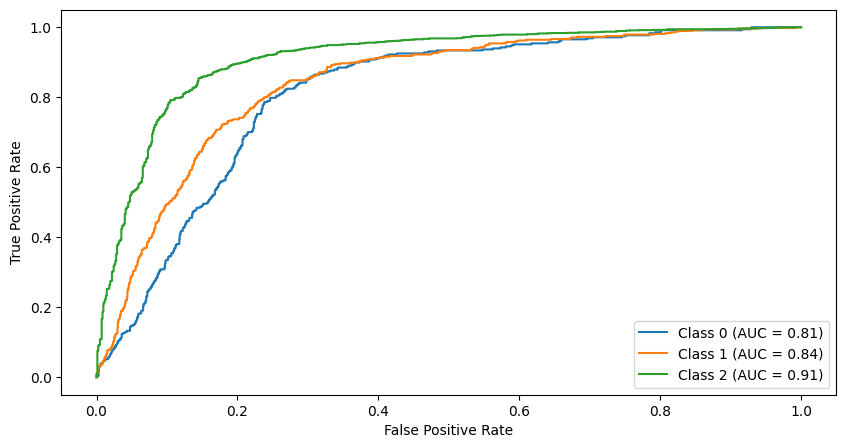

In [ ]:
y_pred_pro = np.exp(preds_output.predictions) / np.sum(np.exp(preds_output.predictions), axis=1, keepdims=True)
y_test = preds_output.label_ids
all_fpr = []
all_tpr = []
all_auc = []

for i in range(3):
    y_test_class = (y_test == i).astype(int)

    fpr, tpr, _ = roc_curve(y_test_class, y_pred_pro[:, i])

    roc_auc = auc(fpr, tpr)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)


plt.figure(figsize=(10, 5))

for i in range(3):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} (AUC = {all_auc[i]:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# XLNet Model

In [ ]:
model_XLNet_name = "xlnet-base-cased"
tokenizer_XLNet = AutoTokenizer.from_pretrained(model_XLNet_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
# Function to tokenize a batch of examples
def tokenizing(sample):
  return tokenizer_XLNet(
    sample["text"],
    # Padding with zero to have the same length
    padding = True,
    # Truncate the examples to the model’s maximum context size (which is 512 for this model)
    truncation = True)

In [ ]:
ds_encoded = ds.map(tokenizing, batched = True, batch_size = None)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
# Remove the text column from the ds_encoded because the model does not use it.
ds_encoded = ds_encoded.remove_columns(['text'])

# converting the label, input_ids, and attention_mask columns to the "torch" format.
ds_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [ ]:
# Pre-trained model with a classification head
model_XLNet = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_XLNet_name,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Defining the training arguments
batch_size = 8
num_epochs = 5

# Name of the model
model_name = f"{model_XLNet_name}-finetuned-climate-change"

# Specify the path to store the fine-tuned model
path_model = '/content'

# Training argument
training_args = TrainingArguments(
  # Output directory
  output_dir = os.path.join(path_model, model_name),
  # Number of epochs
  num_train_epochs = num_epochs,
  # Learning rate
  learning_rate = 0.0001,
  # Batch size for training and validation
  per_device_train_batch_size = batch_size,
  # Weight decay for regularization
  weight_decay = 0.001,
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")

In [ ]:
# Define the trainer
trainer_XLNet = Trainer(
  # Model
  model = model_XLNet,
  # Training argument
  args = training_args,
  compute_metrics = compute_metrics,
  # Train and val Datasets
  train_dataset = ds_encoded["train"],
  # Tokenizer
  tokenizer = tokenizer_XLNet)

In [ ]:
# Start training
trainer_XLNet.train()

Step,Training Loss
500,0.930800
1000,0.902000
1500,0.924800
2000,0.900100
2500,0.898900
3000,0.904100
3500,0.905500
4000,0.902300
4500,0.886200
5000,0.915800


TrainOutput(global_step=5965, training_loss=0.9052692832211336, metrics={'train_runtime': 1289.369, 'train_samples_per_second': 37.006, 'train_steps_per_second': 4.626, 'total_flos': 2654917042815000.0, 'train_loss': 0.9052692832211336, 'epoch': 5.0})

In [ ]:
# model_XLNet.save_pretrained(os.path.join("/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis", 'model_weights_XLNet'))
# tokenizer_XLNet.save_pretrained(os.path.join("/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis", 'tokenizer_weights_XLNet'))

('/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet/tokenizer_config.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet/special_tokens_map.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet/spiece.model',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet/added_tokens.json',
 '/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet/tokenizer.json')

In [ ]:
model_XLNet_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/model_weights_XLNet"
tokenizer_XLNet_weights_path = "/content/drive/MyDrive/Projects/Twitter_Sentiment_analysis/tokenizer_weights_XLNet"

In [ ]:
model_load = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_XLNet_weights_path,
  # Number of labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

In [ ]:
tokenizer_load = AutoTokenizer.from_pretrained(tokenizer_XLNet_weights_path)

In [ ]:
trainer2 = Trainer(
  model = model_load,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = ds_encoded["train"],
  tokenizer = tokenizer_load)

In [ ]:
preds_output = trainer2.predict(ds_encoded["validation"])
print(f"Accuracy: {round(preds_output.metrics['test_accuracy'] * 100, 4)} %")
print(f"Precision: {round(preds_output.metrics['test_precision'] * 100, 4)} %")
print(f"Recall: {round(preds_output.metrics['test_recall'] * 100, 4)} %")
print(f"F1 Score: {round(preds_output.metrics['test_f1'] * 100, 4)} %")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 65.5779 %
Precision: 43.0046 %
Recall: 65.5779 %
F1 Score: 51.9449 %


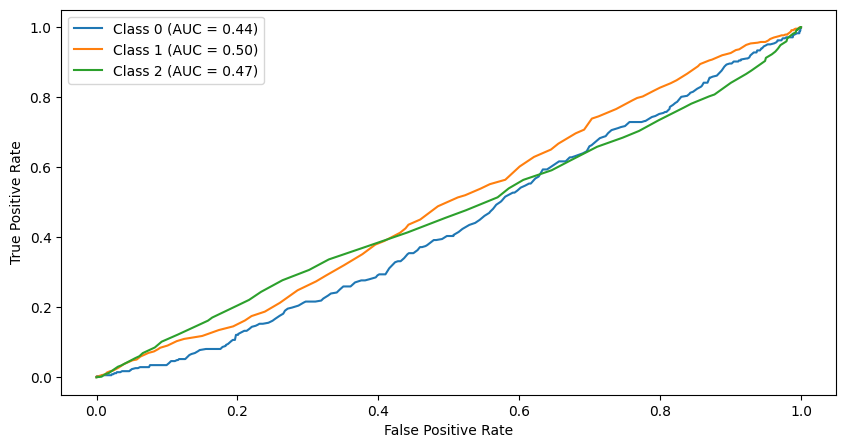

In [ ]:
y_pred_pro = np.exp(preds_output.predictions) / np.sum(np.exp(preds_output.predictions), axis=1, keepdims=True)
y_test = preds_output.label_ids
all_fpr = []
all_tpr = []
all_auc = []

for i in range(3):
    y_test_class = (y_test == i).astype(int)

    fpr, tpr, _ = roc_curve(y_test_class, y_pred_pro[:, i])

    roc_auc = auc(fpr, tpr)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)


plt.figure(figsize=(10, 5))

for i in range(3):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} (AUC = {all_auc[i]:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
